In [1]:
import torch, math
torch.set_printoptions(precision=2, sci_mode=False, linewidth=200)
n_tokens = 30
memory = torch.triu(torch.ones(n_tokens, n_tokens), diagonal=0)
memory = memory * torch.randint_like(memory, 0, n_tokens)
memory = memory + memory.T - torch.diag(memory.diagonal())
memory = memory.long()
memory

tensor([[23,  0, 23,  8,  7,  3,  1, 18, 29, 17,  1, 23, 27,  5, 20, 21, 23, 22, 27, 11, 11, 15,  0, 28, 19, 21, 17, 19,  4, 13],
        [ 0, 18, 29, 26, 26,  8,  0, 25,  0,  1, 23,  0,  2, 12, 25, 26, 14, 19, 26,  5, 25,  0,  5, 22, 26, 14, 19, 19, 28, 11],
        [23, 29, 18, 18,  6, 20, 11,  9,  1, 15, 10, 11,  6, 23, 29, 12, 11,  1, 17, 10,  3, 21,  2, 27,  3, 13, 10,  7, 10, 24],
        [ 8, 26, 18,  4, 11, 29, 20,  6, 16, 11, 29,  2, 16,  6,  5, 27, 29, 18, 29, 16, 19,  7,  4,  2,  6, 16, 14, 14,  3, 26],
        [ 7, 26,  6, 11, 23, 10, 26, 17, 17, 26, 29, 27,  6, 18, 23, 11, 16, 19,  1, 22, 20, 21,  5,  3, 27, 13,  6, 23, 14, 13],
        [ 3,  8, 20, 29, 10, 13, 18, 16, 29, 27,  7,  8, 28, 29, 22, 24, 13, 15, 23, 25, 23,  0, 24,  8, 17,  5, 15,  8, 28, 13],
        [ 1,  0, 11, 20, 26, 18,  6, 15, 13, 22, 21, 20, 23, 26, 18, 15, 26, 23,  9, 24,  0,  4,  4, 28,  9,  1,  8, 21,  0, 19],
        [18, 25,  9,  6, 17, 16, 15, 19, 11,  2, 17,  7,  3,  7,  4,  1, 26, 11, 23, 25, 2

In [2]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm


class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, dim_feedforward, dropout=0.0):
        super().__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.dim_feedforward = dim_feedforward

        self.self_attn = nn.MultiheadAttention(d_model, n_head, batch_first=True, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, tgt, skip_feedforward=False, skip_self_attn=False, linear_mask=None, history=None, custom_attention=False, head_mask=None):
        hist = {}
        attn_heads = None
        if not skip_self_attn:
            # mask = torch.triu(torch.ones(tgt.shape[1], tgt.shape[1]), diagonal=1).bool().to(self.device)
            # tgt2, attn_heads = hist['self_attn_non_residual'] = self.self_attn(tgt, tgt, tgt, attn_mask=mask, average_attn_weights=False)
            tgt2 = hist['self_attn_non_residual'] = self.attn_forward(tgt, self.self_attn, custom_attention, hist, head_mask)
            tgt = hist['self_attn'] = tgt + tgt2
        tgt = hist['norm1'] = self.norm1(tgt)
        if self.dim_feedforward > 0 and not skip_feedforward:
            tgt2 = hist['linear1'] = nn.functional.relu(self.linear1(tgt))
            tgt2 = hist['linear1_dropout'] = self.dropout(tgt2)
            if linear_mask is not None:
                tgt2 = tgt2 * linear_mask
            tgt2 = hist['linear2_non_residual'] = self.linear2(tgt2)
            tgt = hist['linear2'] = tgt + tgt2
        tgt = hist['norm2'] = self.norm2(tgt)
        return tgt if history is None else hist[history], attn_heads
    
    def attn_forward(self, x, attn, custom_attention, history, head_mask=None):
        attn_mask = torch.tril(torch.ones(x.shape[1], x.shape[1]), diagonal=0).to(self.device)
        if not custom_attention:
            return attn(x, x, x, attn_mask=attn_mask)[0]

        batch_size = x.shape[0]
        x = x.transpose(0, 1)
        # this is just torch's attention but expanded so we can modify it
        proj = F.linear(x, attn.in_proj_weight, attn.in_proj_bias)
        proj = proj.unflatten(-1, (3, self.d_model)).unsqueeze(0).transpose(0, -2).squeeze(-2).contiguous()
        q, k, v = proj[0], proj[1], proj[2]
        q = q.unflatten(-1, (self.n_head, self.d_model // self.n_head)).permute(1, 2, 0, 3)
        k = k.unflatten(-1, (self.n_head, self.d_model // self.n_head)).permute(1, 2, 0, 3)
        v = v.unflatten(-1, (self.n_head, self.d_model // self.n_head)).permute(1, 2, 0, 3)
        
        history.update({
            'q': q,
            'k': k,
            'v': v
        })

        attn_mask = attn_mask.masked_fill(attn_mask == False, float('-inf'))
        
        attn_output = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1)) + attn_mask
        attn_output = F.softmax(attn_output, dim=-1)
        attn_output = torch.matmul(attn_output, v)
        attn_output = attn_output.permute(2, 0, 1, 3).contiguous()  # [seq_len, batch_size, n_head, d_model // n_head]
        # apply head mask
        if head_mask is not None:
            attn_output = attn_output * head_mask[None, None, :, None]
        
        history['attn_output'] = attn_output

        attn_output = attn_output.flatten(-2, -1)
        attn_output = F.linear(attn_output, attn.out_proj.weight, attn.out_proj.bias)
        return attn_output.transpose(0, 1)

class ToyTransformer(nn.Module):
    def __init__(self, n_layers, d_model, n_head, hidden_size, n_tokens, max_len, dropout=0.0):
        super().__init__()
        self.n_layers = n_layers
        self.d_model = d_model
        self.n_head = n_head
        self.hidden_size = hidden_size
        self.tokens = list(range(n_tokens))
        self.max_len = max_len

        self.embed = nn.Embedding(n_tokens, embedding_dim=d_model)

        self.layers = nn.ModuleList([
            DecoderLayer(d_model=d_model, n_head=n_head, dim_feedforward=hidden_size)
            for _ in range(n_layers)
        ])
        self.unembed = nn.Linear(d_model, n_tokens)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(
        self,
        x,
        skip_feedforward=False,
        skip_self_attn=False,
        return_before_embedding=False,
        linear_mask=None,
        history=None,
        return_attn_weights=False,
        custom_attention=False,
        head_mask=None):
        if head_mask is not None:
            custom_attention = True
        tgt = self.embed(x)
        tgt = F.pad(tgt, (0, 0, 0, 1))  # [batch_size, seq_len + 1, d_model]
        for layer in self.layers:
            tgt, attn_heads = layer(
                tgt,
                skip_feedforward=skip_feedforward,
                skip_self_attn=skip_self_attn,
                linear_mask=linear_mask,
                history=history,
                custom_attention=custom_attention,
                head_mask=head_mask)
            if history is not None:
                return tgt
        if return_before_embedding:
            return tgt
        x = self.unembed(tgt)
        if return_attn_weights:
            return x, attn_heads
        return x

    def train(self, lr=1e-3, batch_size=128, n_epochs=1000):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for _ in tqdm(range(n_epochs)):
            batch = self.generate_data(batch_size)
            optimizer.zero_grad()
            input = batch[:, :-1]
            output = self(input)
            loss = criterion(output.reshape(-1, len(self.tokens)), batch.reshape(-1))

            loss.backward()
            optimizer.step()

        print('loss: ', loss.item())

    def generate_data(self, batch_size):
        random_indices = torch.randint(0, n_tokens, (batch_size, 2))  # [batch_size, 2]
        next_tokens = memory[random_indices[:, 0], random_indices[:, 1]].unsqueeze(1)  # [batch_size, 1]
        tensor = torch.cat([random_indices, next_tokens], dim=1)
        return tensor.to(self.device)



In [28]:
hidden_size = 64
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model = ToyTransformer(n_layers=1, d_model=16, n_head=4, hidden_size=hidden_size, n_tokens=n_tokens, max_len=3, dropout=0.1).to(device)
model.train(lr=1e-2, n_epochs=3000, batch_size=144 * 2)
samples = 1000
data = model.generate_data(samples)
output = (model(data[:,:-1])[:,-1,:].argmax(dim=-1))
print('Accuracy: ', output.eq(data[:,-1]).sum().item() / samples)
output = (model(data[:,:-1], skip_feedforward=True)[:,-1,:].argmax(dim=-1))
print('Accuracy without feedforward: ', output.eq(data[:,-1]).sum().item() / samples)
output = (model(data[:,:-1], skip_feedforward=True, skip_self_attn=True)[:,-1,:].argmax(dim=-1))
print('Accuracy without both: ', output.eq(data[:,-1]).sum().item() / samples)


  0%|          | 4/3000 [00:00<01:29, 33.61it/s]

100%|██████████| 3000/3000 [00:23<00:00, 128.31it/s]

loss:  8.06153257144615e-05
Accuracy:  1.0
Accuracy without feedforward:  0.094
Accuracy without both:  0.042


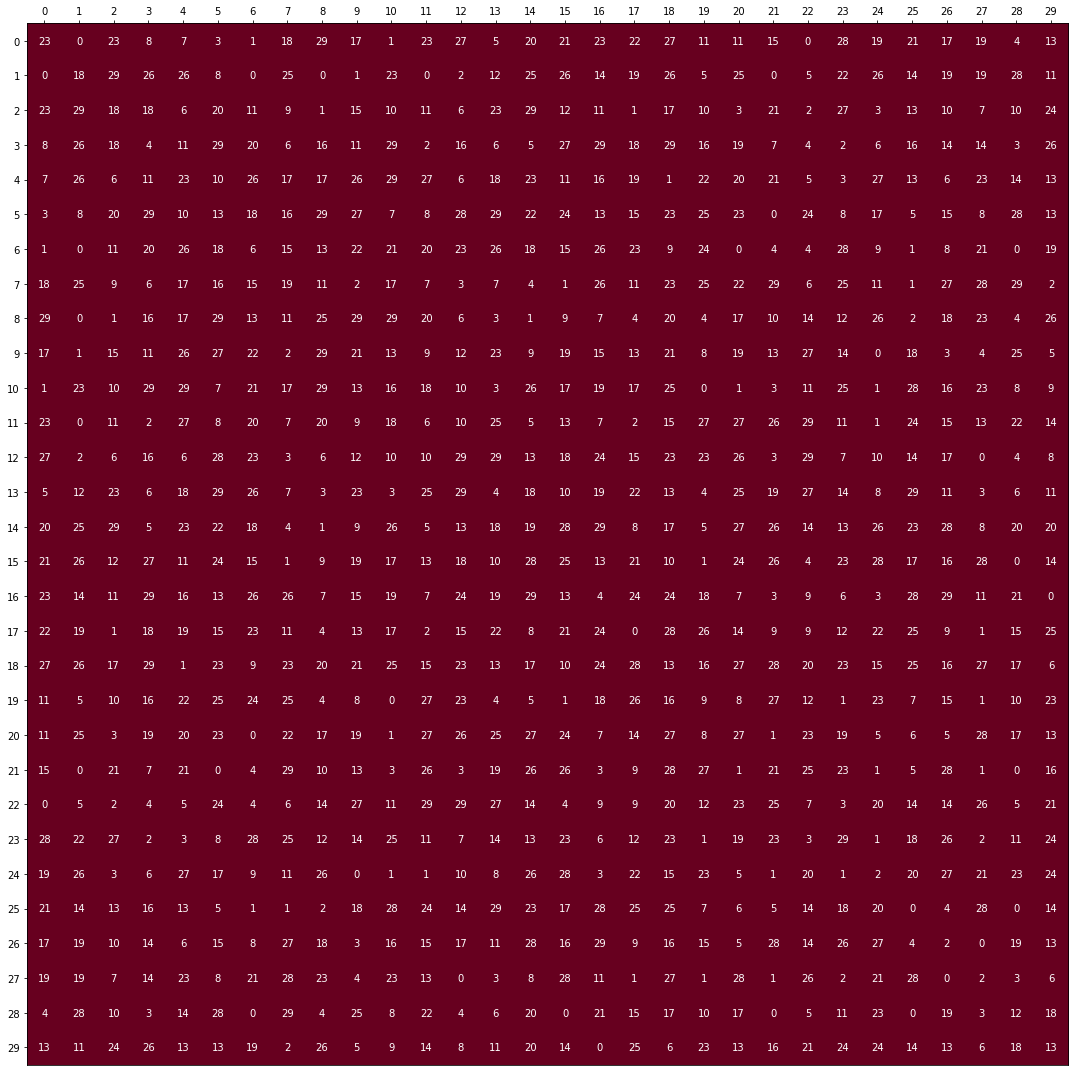

In [6]:
import matplotlib.pyplot as plt

def plot(model_output):
    fig, ax = plt.subplots(figsize=(15, 15))
    accuracy_matrix = model_output.eq(memory).float()
    im = ax.imshow(accuracy_matrix, cmap='RdBu')
    for i in range(n_tokens):
        for j in range(n_tokens):
            t = str(memory[i, j].item()) if accuracy_matrix[i, j].item() == 1.0 else f'{model_output[i, j].item()} ({memory[i, j].item()})'
            text = ax.text(j, i, t,
                           ha="center", va="center", color="w")
    ax.xaxis.tick_top()
    plt.xticks(range(n_tokens), range(n_tokens))
    plt.yticks(range(n_tokens), range(n_tokens))
    fig.tight_layout()
    plt.show()

prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
output = model(prompts)[:,-1,:].argmax(dim=-1).view(n_tokens, n_tokens)
plot(output)

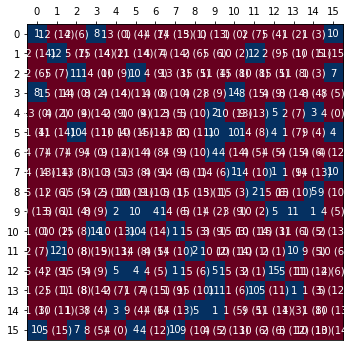

In [8]:
import math
prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
output = model(prompts, head_mask=torch.tensor([0, 1]))[:,-1,:].argmax(dim=-1).view(n_tokens, n_tokens)
plot(output)

In [57]:
torch.set_printoptions(precision=3, sci_mode=False, linewidth=160)
print(model(torch.tensor([[0, 1]]), history='self_attn_non_residual'))
print(model(torch.tensor([[0, 1]]), custom_attention=True, history='self_attn_non_residual'))

tensor([[[-0.406,  0.241, -1.010, -1.013,  0.152,  0.700,  0.053, -0.642,  0.001,  0.020,  0.123,  0.310,  0.496, -0.334, -0.218,  0.003, -0.381,  0.981,
          -0.269,  0.052,  0.658, -0.029,  0.202, -0.212,  1.066, -0.033,  0.493,  0.302, -0.703, -1.064, -0.363,  0.387],
         [-0.414, -0.410,  0.450, -0.364,  0.023,  0.965,  0.157, -0.348, -0.538, -0.056,  0.319, -0.362,  0.672,  0.141,  0.575,  0.206, -0.752,  0.715,
          -0.256, -0.612, -0.067,  0.194, -0.070, -0.074,  0.227,  0.667,  0.318,  0.226, -0.624, -0.355, -0.782,  0.414],
         [-0.235, -0.207, -0.200, -0.247,  0.157,  0.688,  0.105, -0.423, -0.250, -0.061,  0.180, -0.154,  0.674, -0.008,  0.286,  0.154, -0.335,  0.708,
          -0.268, -0.237,  0.224, -0.104,  0.151, -0.223,  0.416,  0.299,  0.243,  0.292, -0.632, -0.480, -0.459,  0.088]]], grad_fn=<TransposeBackward0>)
tensor([[[-0.566,  0.583, -1.792, -1.331,  0.178,  0.732, -0.046, -1.086,  0.127, -0.102,  0.107,  0.513,  0.438, -0.313, -0.495, -0.217,

torch.Size([24, 24, 2, 4])


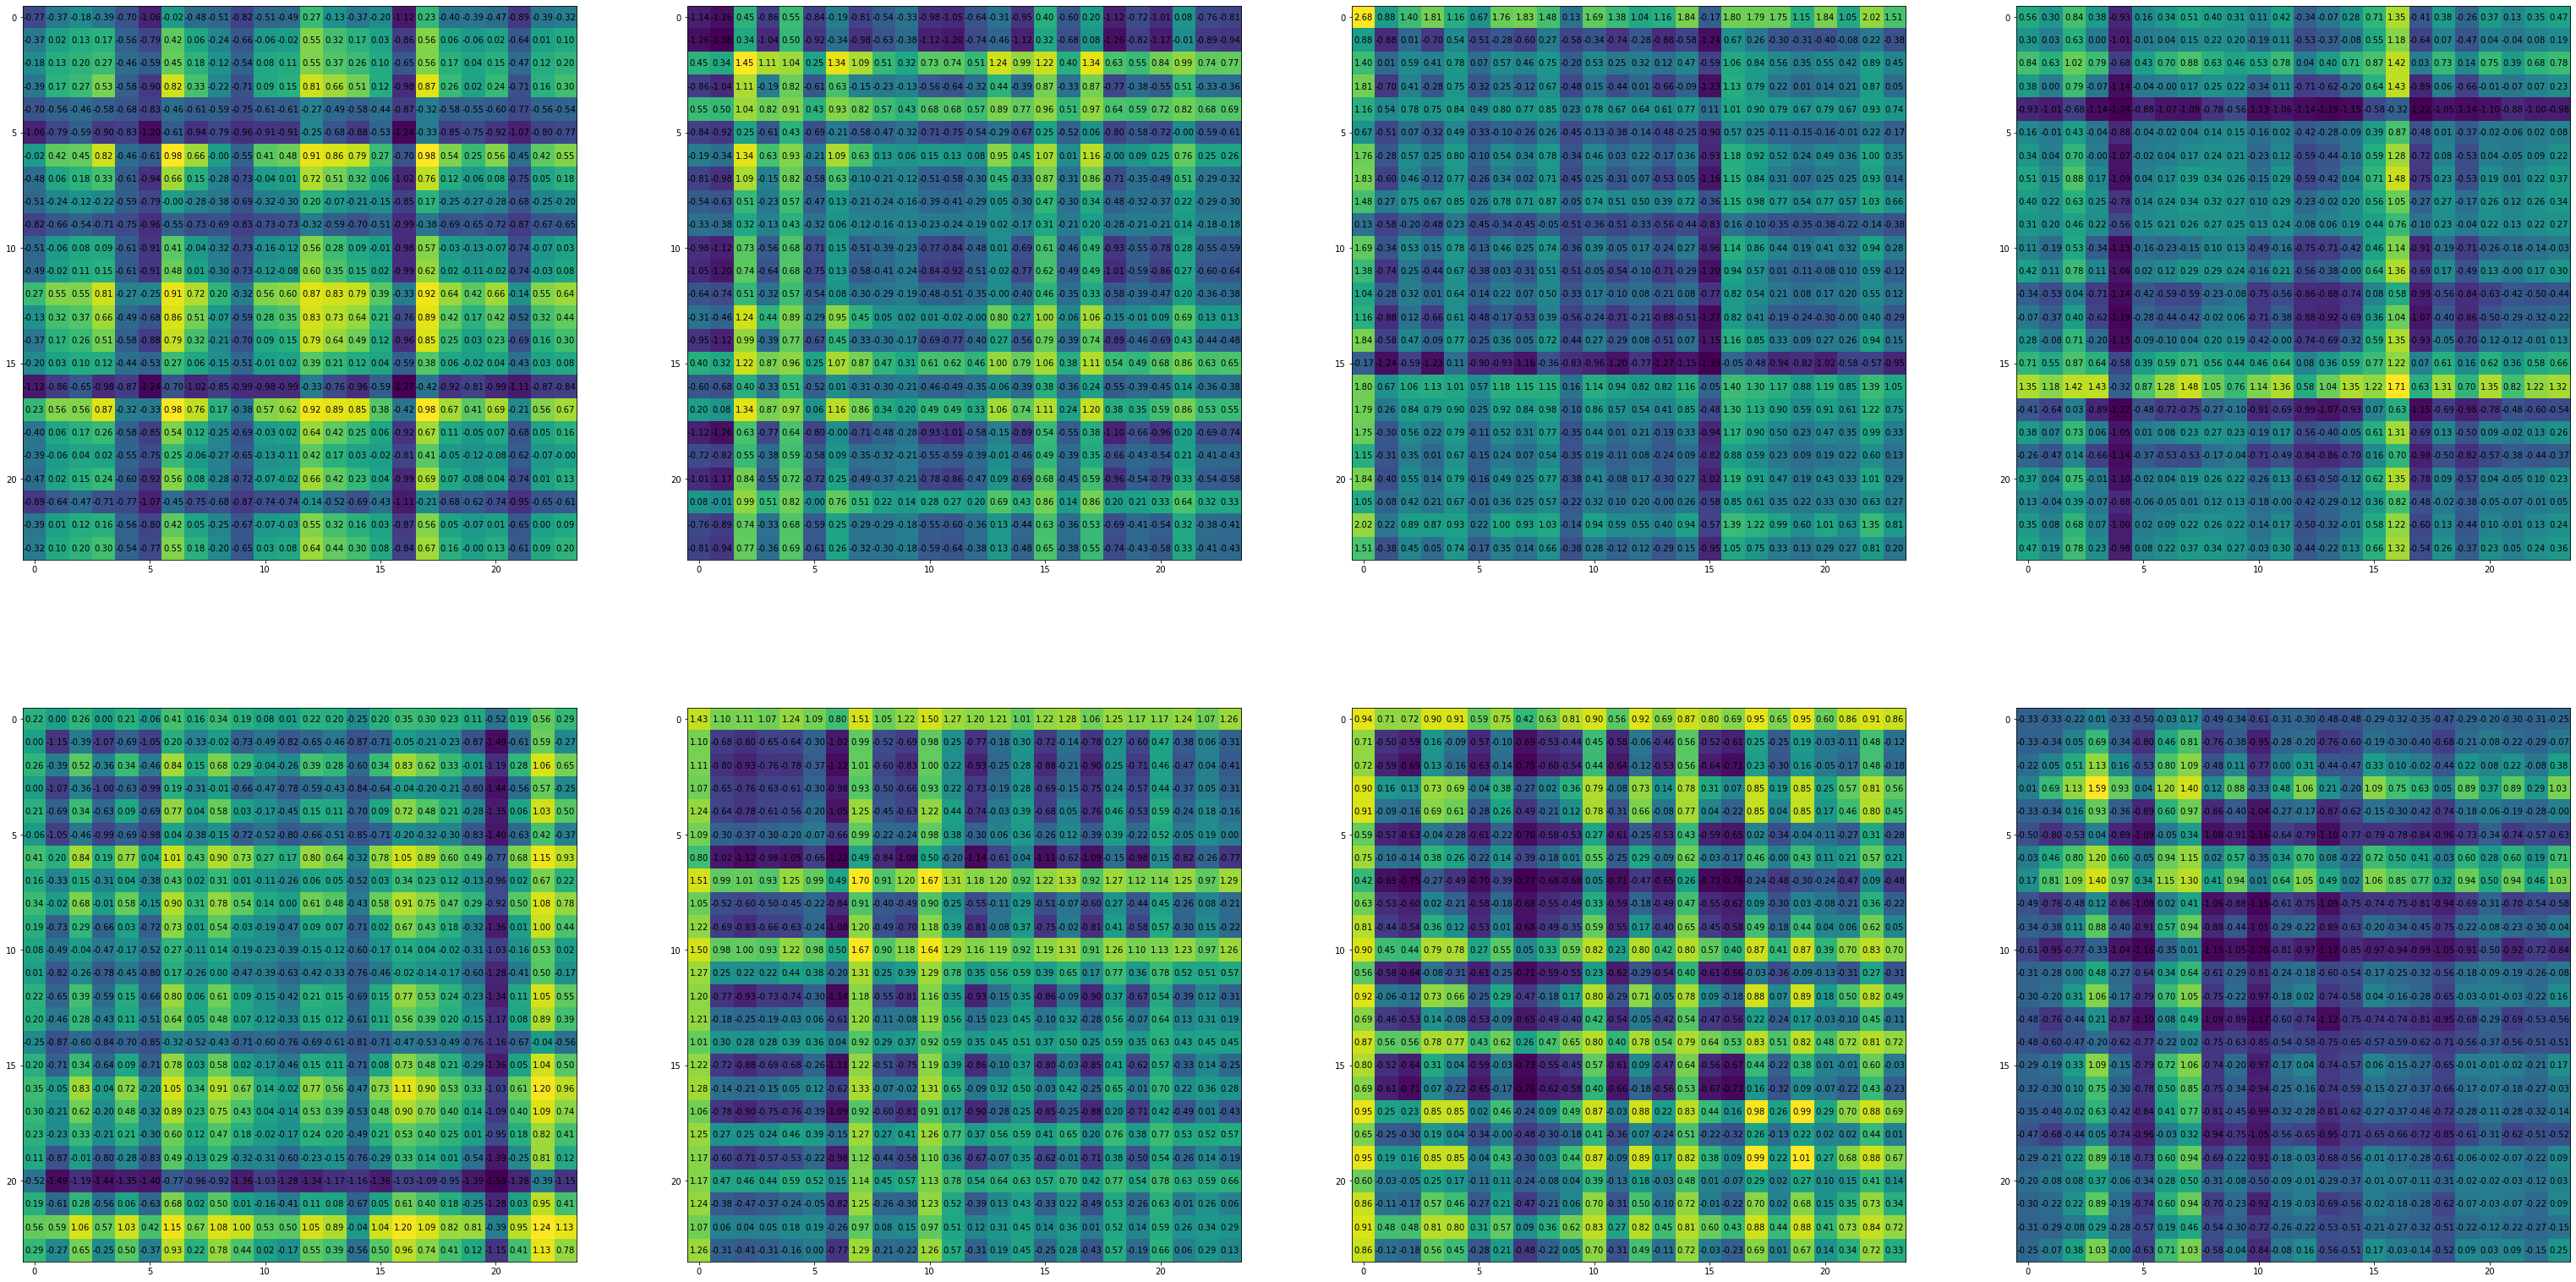

In [39]:
prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
output = model(prompts, custom_attention=True, history='attn_output')[-1].view(n_tokens, n_tokens, model.n_head, -1)
print(output.shape)

fig, axs = plt.subplots(output.size(-2), output.size(-1), figsize=(54, 28))

for i0 in range(output.size(-2)):
    for i2 in range(output.size(-1)):
        ax = axs[i0, i2]
        # plot output[:,:,i] using imshow
        ax.imshow(output[:,:,i0, i2].detach().numpy(), cmap='viridis')
        for j in range(n_tokens):
            for k in range(n_tokens):
                ax.text(k, j, f'{output[j,k,i0, i2]:.2f}', ha='center', va='center', color='black')

torch.Size([24, 24, 2, 4])


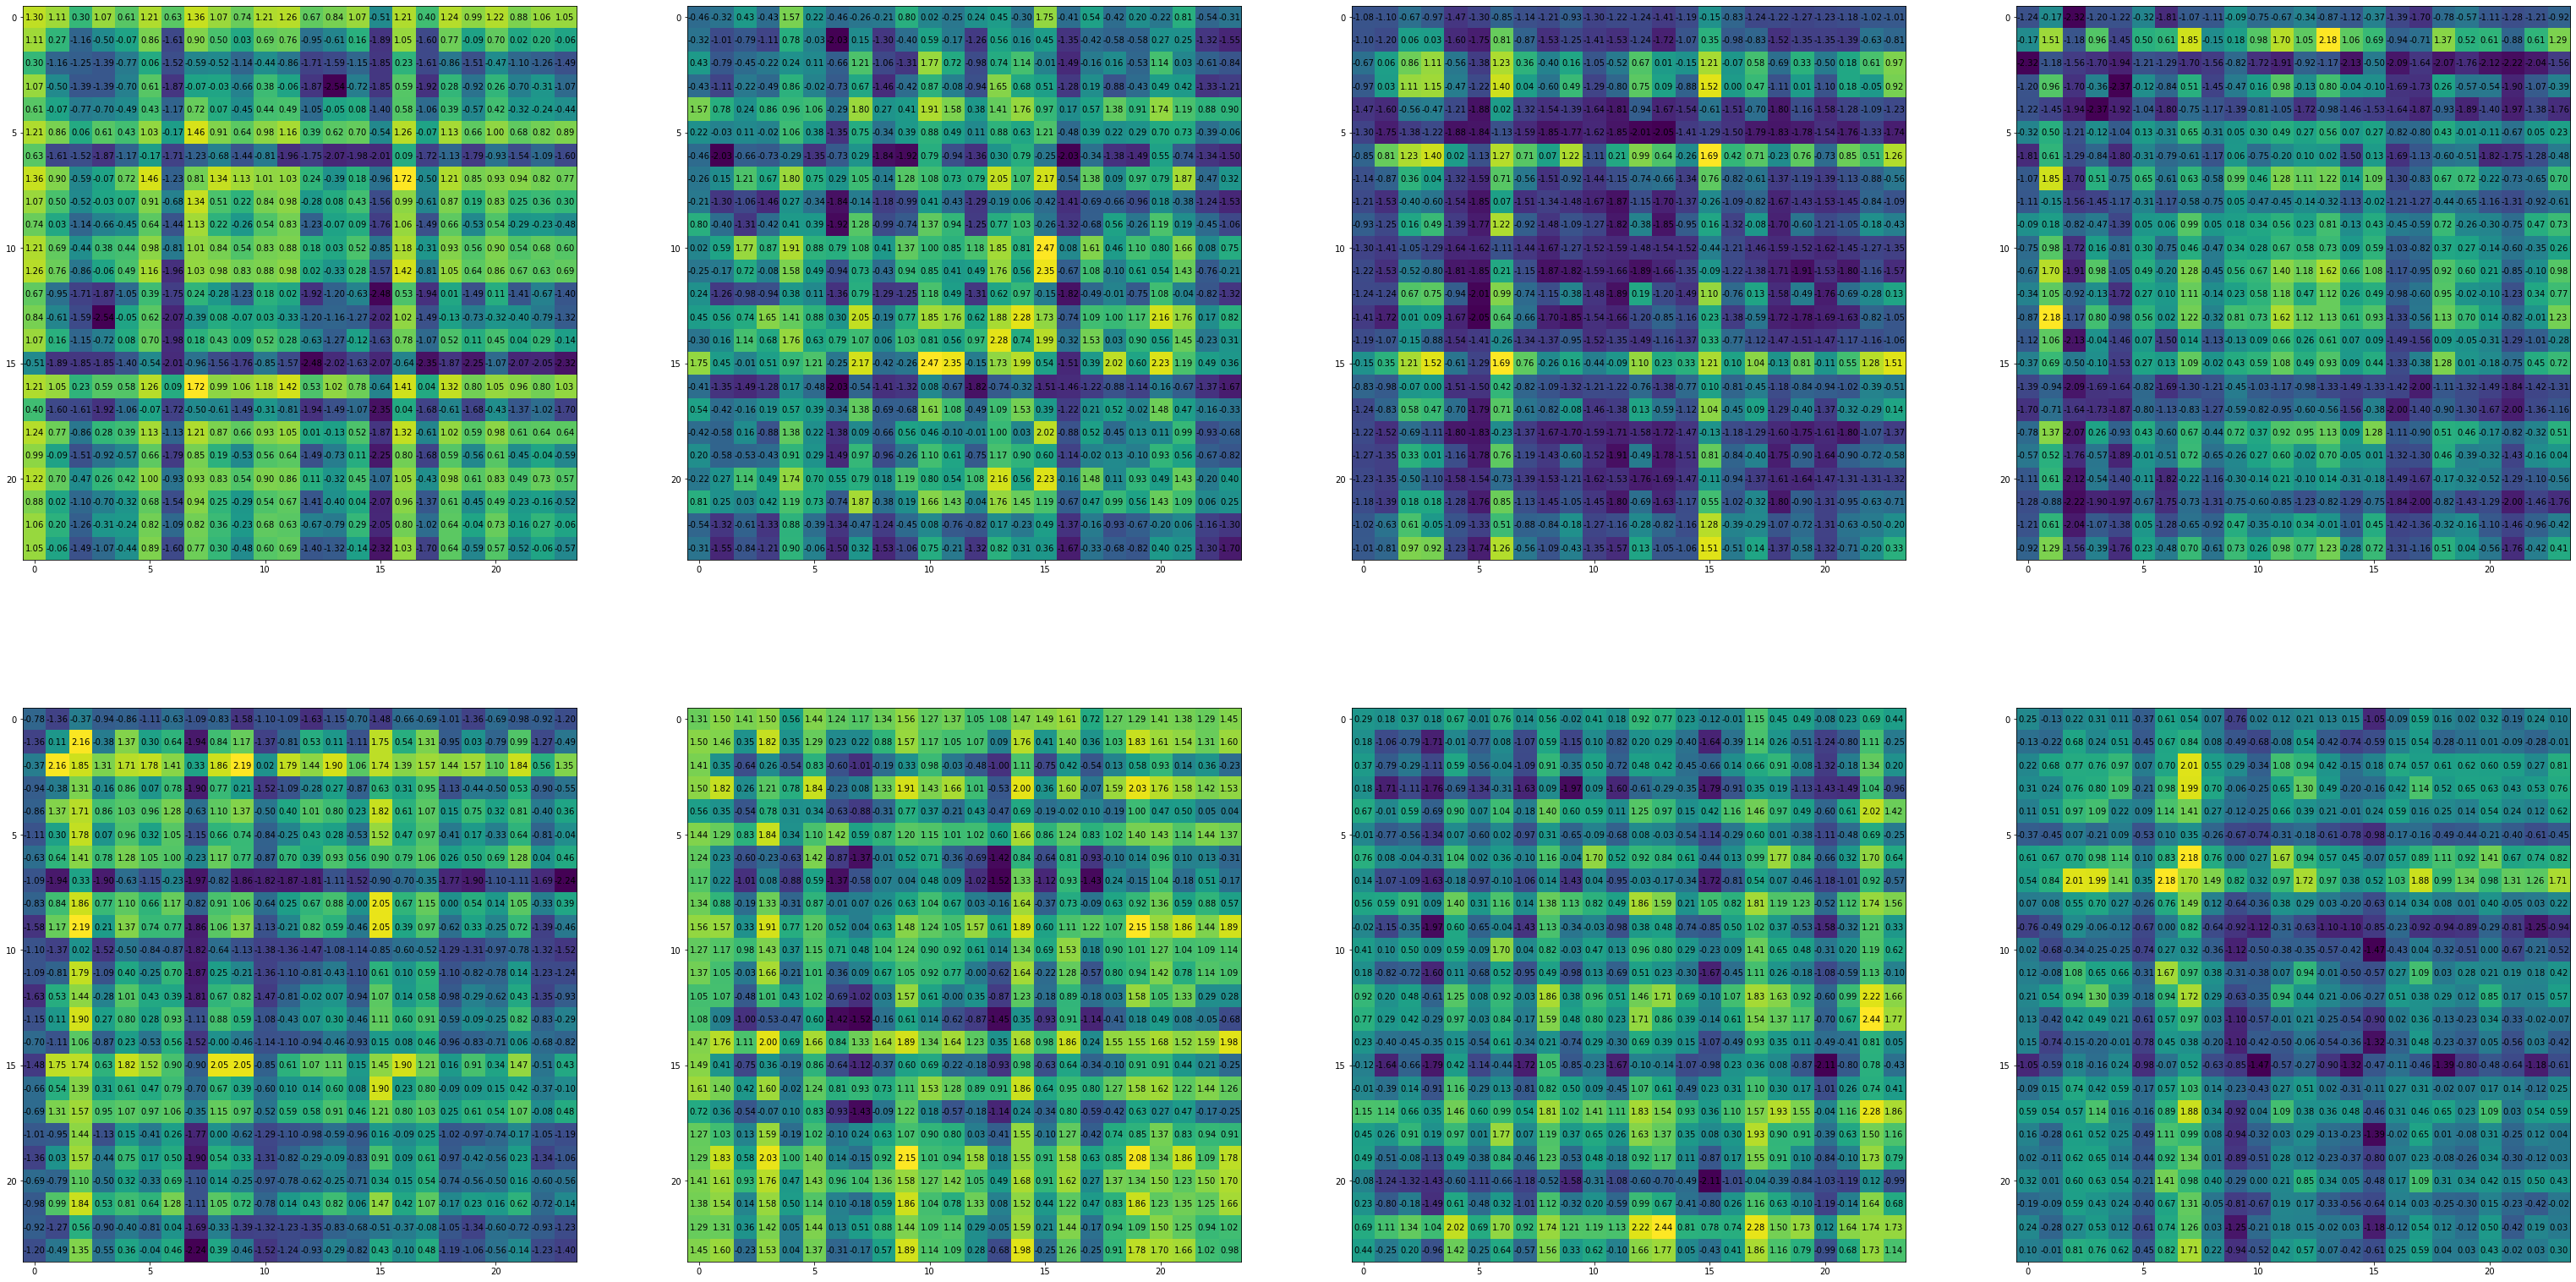

In [44]:
prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
output = model(prompts, custom_attention=True, history='norm1')[:,-1,:].view(n_tokens, n_tokens, model.n_head, -1)
print(output.shape)

fig, axs = plt.subplots(output.size(-2), output.size(-1), figsize=(54, 28))

for i0 in range(output.size(-2)):
    for i2 in range(output.size(-1)):
        ax = axs[i0, i2]
        # plot output[:,:,i] using imshow
        ax.imshow(output[:,:,i0, i2].detach().numpy(), cmap='viridis')
        for j in range(n_tokens):
            for k in range(n_tokens):
                ax.text(k, j, f'{output[j,k,i0, i2]:.2f}', ha='center', va='center', color='black')

In [58]:
import numpy as np
prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
output = model(prompts, custom_attention=True, history='attn_output')[-1]#.view(n_tokens, n_tokens, model.n_head, -1)
print(output.shape)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(100, 100))
for i in range(output.size(1)):
    cosine_sim = torch.cosine_similarity(output[None, :, i, :], output[:, None, i, :], dim=-1)
    ax[i].imshow(cosine_sim.detach().numpy())
    ax[i].set_title(f'Head {i}')
    # put xaxis on top
    ax[i].xaxis.set_ticks_position('top')
    # set xaxis label
    ax[i].set_xlabel('x')
    # set yaxis label
    ax[i].set_ylabel('y')
    # set xticks
    ax[i].set_xticks(np.arange(n_tokens ** 2))
    # set yticks
    ax[i].set_yticks(np.arange(n_tokens ** 2))

    for j in range(n_tokens ** 2):
        for k in range(n_tokens ** 2):
            ax[i].text(k, j, f'{cosine_sim[j,k].item():.2f}', ha='center', va='center', color='black')

torch.Size([900, 8, 4])


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f20783e5480> (for post_execute):


KeyboardInterrupt: 

In [7]:
prompts = torch.tensor([[0, 2]])
q = model(prompts, custom_attention=True, history='q')
print(q[0, :, -1, :])
k = model(prompts, custom_attention=True, history='k')
print(k[0, :, 0, :])
print(k[0, :, 1, :])

tensor([[     0.42,     -0.00,     -0.30,     -0.09],
        [    -0.36,     -0.25,      0.39,     -0.02]], grad_fn=<SliceBackward0>)
tensor([[-0.13,  1.73, -0.79,  0.71],
        [-2.47,  0.06,  0.71, -0.11]], grad_fn=<SliceBackward0>)
tensor([[-0.09,  1.87,  1.67, -0.46],
        [-1.24, -0.01,  3.09, -0.51]], grad_fn=<SliceBackward0>)


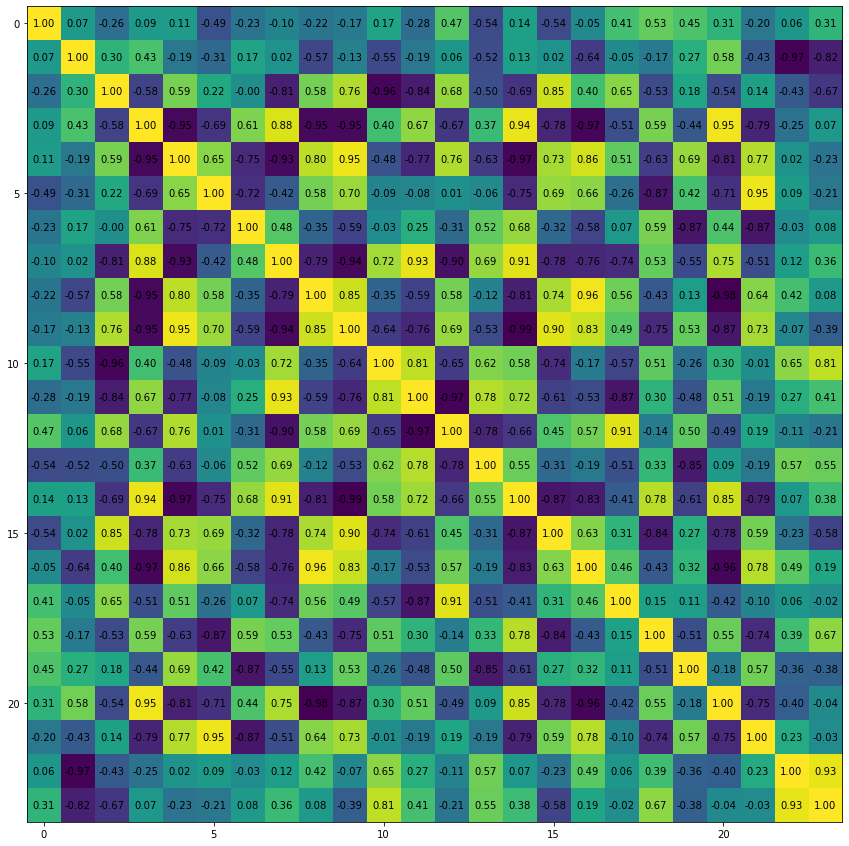

In [37]:
prompts = torch.cartesian_prod(torch.tensor([0]), torch.arange(n_tokens))
k = model(prompts, custom_attention=True, history='k')
head_0_k = k[:, 0, 1, :]
head_1_k = k[:, 1, 1, :]

cosine_similarity = torch.cosine_similarity(head_0_k[None, :, :], head_0_k[:, None, :], dim=-1)
# set figure size
plt.figure(figsize=(15, 15))
plt.imshow(cosine_similarity.detach().numpy())
for i in range(n_tokens):
    for j in range(n_tokens):
        plt.text(i, j, f'{cosine_similarity[i, j].item():.2f}', ha='center', va='center')

In [31]:
a0, b0, a1, b1 = (random.randrange(n_tokens) for _ in range(4))
prompts = torch.tensor([[a0, b0], [a0, b1], [a1, b0], [a1, b1]])
x = model(prompts, history='self_attn')[:,-1,:]
torch.cosine_similarity(x[0] - x[1], x[2] - x[3], dim=0)

tensor(1., grad_fn=<SumBackward1>)

In [32]:
a0, b0, a1, b1, a2, b2 = (random.randrange(n_tokens) for _ in range(6))
prompts = torch.tensor([[a0, b0], [a0, b1], [a2, b2], [a1, b1]])
x = model(prompts, history='norm1')[:,-1,:]
torch.cosine_similarity(x[0] - x[1], x[2] - x[3], dim=0)

tensor(0.08, grad_fn=<SumBackward1>)

In [33]:
x = torch.arange(n_tokens)
x = model.embed(x).unsqueeze(1)
x = torch.cat([x, torch.zeros_like(x), torch.zeros_like(x)], dim=1)

x = model.layers[0].attn_forward(x, model.layers[0].self_attn, custom_attention=True, history={})
first_batch = x[:,-1,:]

x = torch.arange(n_tokens)
x = model.embed(x).unsqueeze(1)
x = torch.cat([torch.zeros_like(x), x, torch.zeros_like(x)], dim=1)

x = model.layers[0].attn_forward(x, model.layers[0].self_attn, custom_attention=True, history={})
second_batch = x[:,-1,:]



In [34]:
cos_similarities = torch.zeros(n_tokens, n_tokens)
print('  ', end=' ')
for i in range(n_tokens):
    print(f'{i:<4}', end=' ')
print()
avg = torch.zeros(model.d_model)

for i in range(n_tokens):
    print(i, end=' ')
    for j in range(n_tokens):
        a = first_batch[i] + second_batch[j]
        # b = model(torch.tensor([[i, j]]), history='norm1')[:,-1,:].squeeze(0)
        # cos = torch.cosine_similarity(model.layers[0].norm1(a), b, dim=0).item()
        b = model(torch.tensor([[i, j]]), history='self_attn')[:,-1,:].squeeze(0)
        cos = torch.cosine_similarity(a, b, dim=0).item()
        cos_similarities[i, j] = cos
        avg += b
        print(f'{cos:.2f}', end=' ')
    print()

print(torch.cosine_similarity(avg / (n_tokens ** 2), b, dim=0))


   0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   
0 0.99 0.98 0.97 0.98 0.96 0.98 0.95 0.94 0.92 0.95 0.96 0.97 0.96 0.98 0.99 0.97 0.98 0.96 0.98 0.96 0.98 0.87 0.96 0.94 0.98 0.93 0.99 0.99 0.96 0.97 
1 0.98 0.98 0.92 0.97 0.97 0.95 0.94 0.96 0.89 0.89 0.95 0.96 0.93 0.94 0.97 0.95 0.97 0.95 0.97 0.94 0.98 0.89 0.93 0.87 0.96 0.88 0.92 0.97 0.91 0.94 
2 0.97 0.92 0.98 0.99 0.95 0.95 0.98 0.95 0.96 0.97 0.96 0.94 0.97 0.97 0.95 0.97 0.95 0.99 0.90 0.94 0.90 0.97 0.94 0.94 0.88 0.95 0.98 0.96 0.95 0.97 
3 0.98 0.97 0.99 0.98 0.96 0.96 0.90 0.96 0.98 0.98 0.96 0.96 0.98 0.98 0.96 0.96 0.98 0.96 0.94 0.93 0.88 0.96 0.97 0.92 0.95 0.97 0.98 0.97 0.96 0.97 
4 0.96 0.97 0.95 0.96 0.97 0.86 0.96 0.95 0.92 0.95 0.96 0.94 0.94 0.98 0.97 0.97 0.97 0.97 0.96 0.97 0.95 0.94 0.95 0.88 0.97 0.92 0.97 0.92 0.94 0.93 
5 0.98 0.95 0.95 0.96 0.86 0.94 0.93 0.94 0.92 0.92 0.81 0.93 0.91 0.94 0.96 0.95

In [37]:
b = model(torch.tensor([[0, 1]]), history='self_attn')[:,-1,:].squeeze(0)
cos_similarities = []
for i in range(n_tokens):
    for j in range(n_tokens):
        a = first_batch[i] + second_batch[j]
        cos_similarities.append([torch.cosine_similarity(a, b, dim=0).item(), [i, j]])
cos_similarities = sorted(cos_similarities, key=lambda x: x[0], reverse=True)
for x in range(10):
    print(cos_similarities[x])

[0.9843145608901978, [0, 1]]
[0.9843145608901978, [1, 0]]
[0.8478116393089294, [0, 0]]
[0.8461593389511108, [1, 20]]
[0.8461593389511108, [20, 1]]
[0.8328648209571838, [0, 20]]
[0.8328648209571838, [20, 0]]
[0.8289934396743774, [1, 13]]
[0.8289934396743774, [13, 1]]
[0.8163436055183411, [0, 19]]


In [64]:
ratios = torch.zeros(n_tokens, n_tokens)
print('  ', end=' ')
for i in range(n_tokens):
    print(f'{i:<4}', end=' ')
print()
for i in range(n_tokens):
    print(i, end=' ')
    for j in range(n_tokens):
        a = first_batch[i] + second_batch[j]
        b = model(torch.tensor([[i, j]]), history='self_attn')[:,-1,:].squeeze(0)
        ratio = a.norm() / b.norm()
        ratios[i, j] = ratio
        print(f'{ratio:.2f}', end=' ')
    print()



   0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   
0 1.11 1.13 1.15 1.09 1.06 1.10 1.05 1.14 1.18 1.14 1.09 1.15 1.04 1.12 1.02 1.06 1.04 1.09 1.05 1.04 1.15 1.04 1.07 1.18 1.07 1.05 1.08 1.02 1.10 1.06 
1 1.13 1.12 1.15 1.10 1.14 1.11 1.11 1.14 1.16 1.18 1.16 1.10 1.11 1.15 1.06 1.07 1.06 1.13 1.15 1.11 1.17 1.12 1.13 1.13 1.14 1.07 1.15 1.03 1.16 1.08 
2 1.15 1.15 1.12 1.10 1.12 1.16 1.12 1.12 1.16 1.19 1.14 1.10 1.11 1.25 1.08 1.08 1.08 1.15 1.10 1.12 1.16 1.11 1.12 1.11 1.19 1.07 1.12 1.04 1.15 1.13 
3 1.09 1.10 1.10 1.10 1.10 1.10 1.03 1.10 1.15 1.14 1.10 1.08 1.06 1.17 0.99 1.11 1.08 1.09 1.11 1.07 1.13 1.07 1.14 1.09 1.17 1.11 1.07 1.04 1.16 1.07 
4 1.06 1.14 1.12 1.10 1.12 1.08 1.06 1.09 1.17 1.13 1.13 1.05 1.10 1.11 1.08 1.01 1.04 1.07 1.12 1.13 1.17 1.11 1.13 1.09 1.12 1.09 1.12 1.04 1.09 1.07 
5 1.10 1.11 1.16 1.10 1.08 1.10 1.10 1.12 1.18 1.11 1.14 1.09 1.04 1.13 1.07 1.06

In [65]:
ratios = torch.zeros(n_tokens, n_tokens)
print('  ', end=' ')
for i in range(n_tokens):
    print(f'{i:<4}', end=' ')
print()
for i in range(n_tokens):
    print(i, end=' ')
    for j in range(n_tokens):
        b = model(torch.tensor([[i, j]]), history='self_attn')[:,-1,:].squeeze(0)
        ratio = b.norm()
        ratios[i, j] = ratio
        print(f'{ratio:.2f}', end=' ')
    print()



   0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   
0 2.91 1.92 1.95 2.17 2.15 1.99 2.21 2.19 2.09 2.02 2.28 1.78 2.15 2.32 1.83 2.10 2.19 1.96 2.09 2.26 1.95 2.19 2.46 2.43 2.08 1.93 2.25 2.53 2.43 2.27 
1 1.92 2.70 1.95 2.18 2.27 2.26 2.05 2.19 2.22 2.20 1.85 2.31 2.08 2.17 2.14 2.33 1.90 1.97 1.73 2.07 2.43 2.04 2.25 2.44 2.10 2.35 1.73 2.15 1.85 2.20 
2 1.95 1.95 2.72 2.32 2.10 2.17 1.81 2.21 2.37 2.05 2.09 1.98 2.14 1.65 1.90 2.21 2.03 1.85 2.18 1.82 2.34 1.88 2.19 2.59 1.73 2.21 1.77 2.43 2.16 1.70 
3 2.17 2.18 2.32 2.82 1.93 2.36 1.97 2.33 2.44 2.00 2.11 1.87 2.16 1.77 2.40 2.35 1.94 2.19 2.09 2.07 2.09 2.25 2.18 2.65 1.64 1.99 2.05 2.09 1.76 2.38 
4 2.15 2.27 2.10 1.93 2.95 2.13 2.09 2.27 2.26 2.30 2.15 2.69 2.35 2.30 1.80 2.48 2.42 2.19 2.28 2.13 2.59 2.20 2.21 2.50 2.45 2.12 1.83 2.30 2.23 2.38 
5 1.99 2.26 2.17 2.36 2.13 3.10 2.09 2.41 2.31 2.36 2.04 2.38 2.45 2.27 2.11 2.30

There isn't a single number below 0! lowest I oculd find is 0.2 but most are >0.8

In [66]:
i = 0
j = 2
a = first_batch[i] + second_batch[j]
b = model(torch.tensor([[i, j]]), history='self_attn')[:,-1,:].squeeze(0)
print(torch.cosine_similarity(a, b, dim=0))

a = a_norm1 = model.layers[0].norm1(a)
b = model(torch.tensor([[i, j]]), history='norm1')[:,-1,:].squeeze(0)
print(torch.cosine_similarity(a, b, dim=0))

a = torch.relu(model.layers[0].linear1(a))
b = model(torch.tensor([[i, j]]), history='linear1')[:,-1,:].squeeze(0)
print(torch.cosine_similarity(a, b, dim=0))
print(a)
a = a_norm1 + model.layers[0].linear2(a)
b = model(torch.tensor([[i, j]]), history='linear2')[:,-1,:].squeeze(0)
print(torch.cosine_similarity(a, b, dim=0))

a = model.layers[0].norm2(a)
b = model(torch.tensor([[i, j]]), history='norm2')[:,-1,:].squeeze(0)
print(torch.cosine_similarity(a, b, dim=0))

a = model.unembed(a)
b = model.unembed(b)
print(a.softmax(dim=-1).topk(1))
print(b.softmax(dim=-1).topk(1))

tensor(0.960, grad_fn=<SumBackward1>)
tensor(0.960, grad_fn=<SumBackward1>)
tensor(0.947, grad_fn=<SumBackward1>)
tensor([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 1.289, 0.000, 0.704, 0.180, 0.000, 0.729, 0.606, 0.585, 0.733, 0.068, 0.000, 0.000, 1.611, 1.699,
        0.000, 0.000, 1.351, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 1.267, 0.000, 0.000, 0.000, 0.882, 1.162, 0.945, 0.000, 0.000, 0.119, 0.000, 0.000,
        0.556, 0.000, 0.000, 0.033, 0.000, 0.000, 1.413, 0.000, 0.000, 0.437, 0.754, 0.000, 0.352, 0.000, 0.695, 0.000, 0.000, 0.000, 0.000, 0.000, 1.476,
        0.000, 0.000, 0.000, 0.168, 0.000, 0.000, 0.221, 0.180, 0.539, 0.315, 0.000, 0.021, 0.152, 0.000, 0.000, 0.000, 0.000, 1.240, 0.828, 0.000, 0.000,
        0.918, 0.319, 0.000, 1.083, 0.000, 0.000, 0.362, 0.000, 0.000, 0.113, 0.000, 0.418, 0.534, 1.027, 1.315, 0.000, 0.856, 0.000, 0.000, 0.123, 0.000,
        0.285, 0.000, 0.000, 1.545, 0.000, 0.308, 0.000, 0.000, 0.202, 0.136, 0.000, 0.000, 0.000, 0.000, 0.000

The MLP essentially overfits to map each vector of the combined information to the difference between the combined information and the output. This is probably why so many neurons are needed (128 for 450 pieces of information)

torch.return_types.topk(
values=tensor([[0.39]], grad_fn=<TopkBackward0>),
indices=tensor([[16]]))

In [79]:
class Autoencoder(nn.Module):
    def __init__(self, d_model, hidden_dim):
        super().__init__()
        self.d_model = d_model
        self.linear1 = nn.Linear(d_model, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, d_model)
    
    def forward(self, x):
        h = F.relu(self.linear1(x))
        return self.linear2(h), h

    def train(self, epochs=1000, batch_size=200, lr=1e-2, print_every=1000, alpha=0.1):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        total_loss0 = 0
        total_loss1 = 0
        for i in range(epochs):
            optimizer.zero_grad()
            x = model.generate_data(batch_size)
            x = model(x, history='linear1')[:,-1,:]
            x_hat, h = self.forward(x)
            loss0 = criterion(x_hat, x)
            loss1 = alpha * torch.norm(h, p=1, dim=-1).mean()
            total_loss0 += loss0.item()
            total_loss1 += loss1.item()
            loss = loss0 + loss1
            loss.backward()
            optimizer.step()
            if i % print_every == 0 and i > 0:
                print(f'Epoch {i}: loss0 {total_loss0/print_every:.6f}, loss1 {total_loss1/(print_every*alpha):.6f}')
                total_loss0 = 0
                total_loss1 = 0

In [86]:
autoenc = Autoencoder(d_model=model.hidden_size, hidden_dim=1000)
autoenc.train(epochs=10000, lr=1e-2, alpha=0.001)

Epoch 1000: loss0 0.013988, loss1 7.610506
Epoch 2000: loss0 0.005757, loss1 4.156630
Epoch 3000: loss0 0.005891, loss1 3.489014
Epoch 4000: loss0 0.005985, loss1 3.225335


KeyboardInterrupt: 

In [87]:
prompts = torch.cartesian_prod(torch.arange(n_tokens), torch.arange(n_tokens))
output = model(prompts, history='linear1')[:,-1,:]
out, h = autoenc(output)
for i, prompt in enumerate(prompts):
    print('-----')
    print(prompt.tolist())
    # print number of nonzero elements
    print(h[i].nonzero().flatten())

-----
[0, 0]
tensor([290, 316, 464, 508, 612, 616, 866, 912, 926, 954])
-----
[0, 1]
tensor([ 35, 315, 593, 613, 616, 866, 912, 926, 954])
-----
[0, 2]
tensor([464, 570])
-----
[0, 3]
tensor([316, 508, 522, 534, 593, 740, 835, 866, 869, 912, 954])
-----
[0, 4]
tensor([ 10, 267, 290, 376, 464, 612, 616, 697, 866, 926])
-----
[0, 5]
tensor([ 10, 192, 290, 376, 464, 482, 593, 616, 636, 866, 919, 926])
-----
[0, 6]
tensor([316, 443, 508, 522, 534, 835, 927, 954])
-----
[0, 7]
tensor([245, 287, 316, 464, 508, 570, 921, 926])
-----
[0, 8]
tensor([290, 315, 316, 612, 866, 912, 921, 926, 954])
-----
[0, 9]
tensor([316, 522, 740, 866, 912, 926, 954])
-----
[0, 10]
tensor([290, 316, 464, 508, 534, 612, 835, 921, 954])
-----
[0, 11]
tensor([ 10, 125, 464, 593, 740, 835, 866, 912, 954])
-----
[0, 12]
tensor([ 35, 316, 613, 740, 912, 954])
-----
[0, 13]
tensor([190, 449, 553, 593, 740, 835, 927])
-----
[0, 14]
tensor([316, 464, 508, 522, 612, 835, 866, 912, 926, 954])
-----
[0, 15]
tensor([190, 443